# Pairs Creation

1. Load Dataset
2. Uniform Sampling From Ultrafeedback
3. Pairs Creation
   1. Standard DPO pairs (Chosen =  highest overall_score, rejected = lowest overall_score)
   2. Diversity-aware DPO pairs (Chosen = highest avg. embedding distance above threshold, lowest avg. embedding distance below threshold)
   3. Diversity-aware DPO pairs (Chosen = highest LLM-as-judge diversity above threshold, lowest LLM-as-judge diversity above threshold) 
   

In [27]:
from datasets import load_from_disk
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from openai import OpenAI, RateLimitError
import numpy as np
from tqdm import tqdm
import time

from dotenv import load_dotenv
load_dotenv()

from sklearn.metrics.pairwise import cosine_distances

## Load Ultrafeedback Dataset

In [ ]:
# ============================================================
# LOAD THE ULTRAFEEDBACK DATASET WITH CREATIVITY SCORES
# ============================================================

# Path to the dataset (update if different location)
dataset_path = "../data/final_lamini_informational_creative_dataset_uf"

# Load the dataset
dataset = load_from_disk(dataset_path)

print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"Total samples: {len(dataset):,}")
print(f"Number of features: {len(dataset.features)}")
print()

# ============================================================
# DISPLAY BASIC INFO
# ============================================================

print("=" * 80)
print("FEATURE NAMES")
print("=" * 80)
for i, feature in enumerate(dataset.features, 1):
    print(f"{i:2d}. {feature}")
print()

# ============================================================
# SHOW EXAMPLE SAMPLE
# ============================================================

print("=" * 80)
print("EXAMPLE SAMPLE (index 0)")
print("=" * 80)
example = dataset[0]

# Display instruction
print(f"\n📝 INSTRUCTION:")
print(f"   {example['instruction'][:200]}...")

# Display creativity classification
print(f"\n🎨 CREATIVITY CLASSIFICATION:")
print(f"   Label: {example['label']}")
print(f"   Factual score: {example['factual_score']:.4f}")
print(f"   Creative score: {example['creative_score']:.4f}")

# Display number of responses
print(f"\n🤖 RESPONSES:")
print(f"   Number of models: {example['num_models']}")

# Show each response with scores
for i in range(1, example['num_models'] + 1):
    answer_key = f'answer_{i}'
    fg_score_key = f'fine-grained_score_{i}'
    ov_score_key = f'overall_score_{i}'
    
    if answer_key in example and example[answer_key]:
        print(f"\n   Model {i}:")
        print(f"   - Answer: {example[answer_key][:100]}...")
        print(f"   - Fine-grained score: {example[fg_score_key]:.2f}")
        print(f"   - Overall score: {example[ov_score_key]:.2f}")

# ============================================================
# CONVERT TO PANDAS FOR ANALYSIS
# ============================================================

print("\n" + "=" * 80)
print("CONVERTING TO PANDAS")
print("=" * 80)

# Select key columns for analysis (drop nested structures)
columns_to_keep = [
    'instruction', 'label', 'factual_score', 'creative_score',
    'num_models', 'answer_1', 'answer_2', 'answer_3', 'answer_4',
    'fine-grained_score_1', 'fine-grained_score_2', 'fine-grained_score_3', 'fine-grained_score_4',
    'overall_score_1', 'overall_score_2', 'overall_score_3', 'overall_score_4'
]

df = dataset.to_pandas()[columns_to_keep]
print(f"Dataframe shape: {df.shape}")
print()

# ============================================================
# STATISTICS
# ============================================================

print("=" * 80)
print("CREATIVITY DISTRIBUTION")
print("=" * 80)
print(df['label'].value_counts())
print()
print(f"Mean creative score: {df['creative_score'].mean():.4f}")
print(f"Mean factual score: {df['factual_score'].mean():.4f}")
print()

print("=" * 80)
print("QUALITY SCORES STATISTICS")
print("=" * 80)
for i in range(1, 5):
    col = f'overall_score_{i}'
    if col in df.columns:
        print(f"Overall score {i}: mean={df[col].mean():.2f}, std={df[col].std():.2f}")

print("\n✅ Dataset loaded successfully!")
print(f"Use 'dataset' for HuggingFace Dataset object")
print(f"Use 'df' for Pandas DataFrame")

DATASET OVERVIEW
Total samples: 63,967
Number of features: 22

FEATURE NAMES
 1. source
 2. instruction
 3. models
 4. completions
 5. correct_answers
 6. incorrect_answers
 7. num_models
 8. answer_1
 9. fine-grained_score_1
10. overall_score_1
11. answer_2
12. fine-grained_score_2
13. overall_score_2
14. answer_3
15. fine-grained_score_3
16. overall_score_3
17. answer_4
18. fine-grained_score_4
19. overall_score_4
20. label
21. factual_score
22. creative_score

EXAMPLE SAMPLE (index 0)

📝 INSTRUCTION:
   Can you write a C++ program that prompts the user to enter the name of a country and checks if it borders the Mediterranean Sea? Here's some starter code to help you out:
#include <iostream>
#include ...

🎨 CREATIVITY CLASSIFICATION:
   Label: factual
   Factual score: 0.6527
   Creative score: 0.3473

🤖 RESPONSES:
   Number of models: 4

   Model 1:
   - Answer: int main() {
    string country;
    // prompt user for input
    cout << "Enter the name of a count...
   - Fine-grained 

<Axes: xlabel='creative_score', ylabel='Count'>

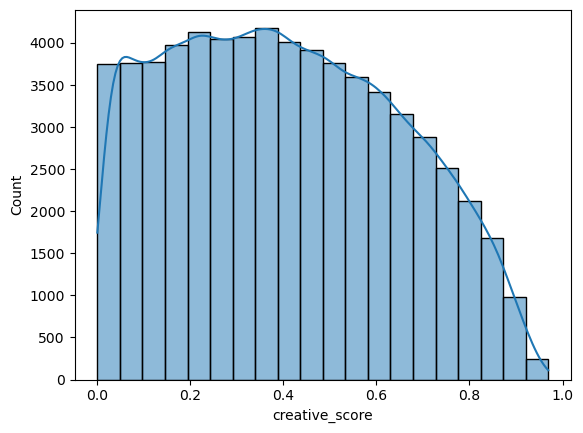

In [8]:
sns.histplot(df['creative_score'], bins=20, kde=True)

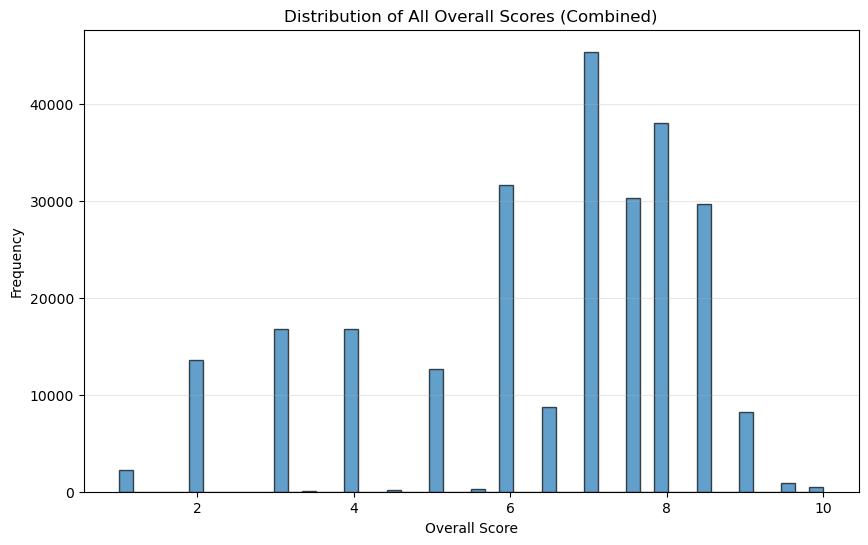

Total scores plotted: 255,864
Min score: 1.00
Max score: 10.00
Mean score: 6.44


In [9]:
all_scores = pd.concat([
    df['overall_score_1'],
    df['overall_score_2'],
    df['overall_score_3'],
    df['overall_score_4']
]).dropna()

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(all_scores, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Overall Score')
plt.ylabel('Frequency')
plt.title('Distribution of All Overall Scores (Combined)')
plt.grid(axis='y', alpha=0.3)
plt.show()

print(f"Total scores plotted: {len(all_scores):,}")
print(f"Min score: {all_scores.min():.2f}")
print(f"Max score: {all_scores.max():.2f}")
print(f"Mean score: {all_scores.mean():.2f}")

## Uniform Sampling from Ultrafeedback

In [29]:
# ============================================================
# PARAMETERS - Adjust these to experiment
# ============================================================

TARGET_PAIRS = 5000          # Total pairs to generate
NUM_BINS = 5                 # Bins over creative_score
QUALITY_THRESH = 5       # Min overall_score to be valid
MIN_VALID_ANSWERS = 3     # Minimum high-quality answers required
MIN_DIVERSITY_GAP = 0.0      # Min |div(chosen) - div(rejected)|
EMBED_MODEL = "text-embedding-3-large"
LLM_JUDGE_MODEL = "Qwen/Qwen2.5-72B-Instruct-Turbo"  # Together API
RANDOM_SEED = 42

# Sampling buffer (sample extra to account for filtering)
SAMPLE_MULTIPLIER = 1.5      # Sample 1.5x target per bin

pairs_per_bin = TARGET_PAIRS // NUM_BINS
sample_per_bin = int(pairs_per_bin * SAMPLE_MULTIPLIER)

print(f"Target: {pairs_per_bin} pairs per bin")
print(f"Will sample: {sample_per_bin} rows per bin")
print(f"Quality threshold: {QUALITY_THRESH}")
print(f"Preferred valid answers: {PREFERRED_VALID_ANSWERS}/{4}")

Target: 1000 pairs per bin
Will sample: 1500 rows per bin
Quality threshold: 5
Preferred valid answers: 3/4


In [15]:
# ============================================================
# BIN PROMPTS BY CREATIVE SCORE
# ============================================================

import numpy as np
import pandas as pd

# Define bin edges
bin_edges = np.linspace(0.0, 1.0, NUM_BINS + 1)
print(f"Bin edges: {bin_edges}")

# Add alpha and alpha_bin columns
df['alpha'] = df['creative_score']
df['alpha_bin'] = pd.cut(
    df['alpha'], 
    bins=bin_edges, 
    labels=range(NUM_BINS), 
    include_lowest=True
)

# Check distribution
print("\nRows per bin:")
print(df['alpha_bin'].value_counts().sort_index())

Bin edges: [0.  0.2 0.4 0.6 0.8 1. ]

Rows per bin:
alpha_bin
0    15685
1    17023
2    15568
3    11778
4     3913
Name: count, dtype: int64


In [16]:
# ============================================================
# SAMPLE ROWS FROM EACH BIN
# ============================================================

sampled_rows = []

for bin_idx in range(NUM_BINS):
    bin_df = df[df['alpha_bin'] == bin_idx]
    available = len(bin_df)
    
    if available < sample_per_bin:
        print(f"⚠️  Bin {bin_idx}: Only {available} rows available (need {sample_per_bin})")
        sampled = bin_df
    else:
        sampled = bin_df.sample(n=sample_per_bin, random_state=RANDOM_SEED + bin_idx)
    
    sampled_rows.append(sampled)
    print(f"✓ Bin {bin_idx}: Sampled {len(sampled)} rows")

# Combine all sampled rows
df_sampled = pd.concat(sampled_rows, ignore_index=True)
print(f"\n📊 Total sampled: {len(df_sampled)} rows")
print(f"📊 This will reduce embedding calls significantly!")

✓ Bin 0: Sampled 1500 rows
✓ Bin 1: Sampled 1500 rows
✓ Bin 2: Sampled 1500 rows
✓ Bin 3: Sampled 1500 rows
✓ Bin 4: Sampled 1500 rows

📊 Total sampled: 7500 rows
📊 This will reduce embedding calls significantly!


## Pairs Creation


In [17]:
# ============================================================
# HELPER FUNCTIONS
# ============================================================

def is_creative_prompt(row):
    """Determine if prompt is creative or factual."""
    return row['creative_score'] >= row['factual_score']

def get_valid_candidates(row):
    """
    Returns: (valid_indices, answers, scores) or (None, None, None) if insufficient
    """
    answers = [row['answer_1'], row['answer_2'], row['answer_3'], row['answer_4']]
    scores = [
        row['overall_score_1'], 
        row['overall_score_2'], 
        row['overall_score_3'], 
        row['overall_score_4']
    ]
    
    valid_idxs = []
    for i in range(4):
        # Check: score exists, is above threshold, answer exists
        if (pd.notna(scores[i]) and 
            scores[i] >= QUALITY_THRESH and 
            pd.notna(answers[i]) and 
            str(answers[i]).strip() != ''):
            valid_idxs.append(i)
    
    if len(valid_idxs) < MIN_VALID_ANSWERS:
        return None, None, None
    
    return valid_idxs, answers, scores

print("✓ Helper functions defined")

✓ Helper functions defined


In [18]:
# ============================================================
# FILTER ROWS FOR ≥3 VALID RESPONSES
# ============================================================

rows_to_process = []
warning_count_3_valid = 0

for idx, row in df_sampled.iterrows():
    valid_idxs, answers, scores = get_valid_candidates(row)
    
    if valid_idxs is None:
        continue  # Skip: insufficient valid answers
    
    # Track 3/4 cases
    if len(valid_idxs) == 3:
        warning_count_3_valid += 1
    
    rows_to_process.append({
        'original_idx': idx,
        'row': row,
        'valid_idxs': valid_idxs,
        'answers': answers,
        'scores': scores,
        'num_valid': len(valid_idxs)
    })

print(f"✓ Rows passing quality filter: {len(rows_to_process)}/{len(df_sampled)}")
print(f"⚠️  Rows with only 3/4 valid answers: {warning_count_3_valid}")
print(f"✓ Rows with all 4/4 valid answers: {len(rows_to_process) - warning_count_3_valid}")
print(f"\n📊 Will embed {sum(r['num_valid'] for r in rows_to_process)} total answers")

✓ Rows passing quality filter: 6105/7500
⚠️  Rows with only 3/4 valid answers: 1904
✓ Rows with all 4/4 valid answers: 4201

📊 Will embed 22516 total answers


In [19]:
# ============================================================
# COMPUTE EMBEDDINGS IN BATCHES
# ============================================================

from openai import OpenAI, RateLimitError
import numpy as np
from tqdm import tqdm
import time
from dotenv import load_dotenv

load_dotenv()
client = OpenAI()

def get_embeddings_batch(texts, model=EMBED_MODEL, batch_size=50):
    """Get embeddings in batches with retry logic for rate limits."""
    all_embeddings = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding"):
        batch = texts[i:i+batch_size]
        
        # Retry with exponential backoff
        max_retries = 5
        for attempt in range(max_retries):
            try:
                response = client.embeddings.create(
                    input=batch,
                    model=model
                )
                batch_embeddings = [item.embedding for item in response.data]
                all_embeddings.extend(batch_embeddings)
                break
            except RateLimitError as e:
                if attempt == max_retries - 1:
                    raise
                wait_time = 2 ** attempt
                print(f"\n⏳ Rate limited. Waiting {wait_time}s...")
                time.sleep(wait_time)
        
        time.sleep(0.2)  # Small delay between batches
    
    return np.array(all_embeddings)

# Collect all texts to embed
all_texts = []
text_to_row_mapping = []

for row_idx, row_data in enumerate(rows_to_process):
    for valid_idx in row_data['valid_idxs']:
        answer_text = row_data['answers'][valid_idx]
        all_texts.append(str(answer_text))
        text_to_row_mapping.append((row_idx, valid_idx))

print(f"📝 Prepared {len(all_texts)} texts for embedding")
print(f"💰 Estimated cost: ~${len(all_texts) * 200 * 0.13 / 1_000_000:.2f}")

# Get embeddings
embeddings = get_embeddings_batch(all_texts)
print(f"✓ Got embeddings with shape: {embeddings.shape}")

📝 Prepared 22516 texts for embedding
💰 Estimated cost: ~$0.59


Embedding: 100%|██████████| 451/451 [07:45<00:00,  1.03s/it]


✓ Got embeddings with shape: (22516, 3072)


In [20]:
# ============================================================
# COMPUTE DIVERSITY SCORES PER ROW
# ============================================================

from sklearn.metrics.pairwise import cosine_distances

def compute_diversity_scores(embeddings_subset):
    """
    Given embeddings for one prompt's valid answers,
    return diversity score for each (mean distance to others).
    """
    if len(embeddings_subset) < 2:
        return [0.0]
    
    # Cosine distances
    dist_matrix = cosine_distances(embeddings_subset)
    
    # Diversity = mean distance to all others
    diversity_scores = []
    for i in range(len(embeddings_subset)):
        # Exclude self (distance = 0)
        other_distances = [dist_matrix[i][j] for j in range(len(embeddings_subset)) if i != j]
        diversity_scores.append(np.mean(other_distances))
    
    return diversity_scores

# Assign diversity scores back to rows
embedding_idx = 0
for row_data in rows_to_process:
    num_valid = row_data['num_valid']
    row_embeddings = embeddings[embedding_idx:embedding_idx+num_valid]
    
    diversity_scores = compute_diversity_scores(row_embeddings)
    row_data['diversity_scores'] = diversity_scores
    row_data['embeddings'] = row_embeddings  # Store for later
    
    embedding_idx += num_valid

print(f"✓ Computed diversity scores for {len(rows_to_process)} rows")
print(f"Example diversity scores (first row): {rows_to_process[0]['diversity_scores']}")

✓ Computed diversity scores for 6105 rows
Example diversity scores (first row): [np.float64(0.44206157766243787), np.float64(0.30580082769633204), np.float64(0.3072506738754396)]


In [21]:
# ============================================================
# APPLY MIN_DIVERSITY_GAP FILTER (FINAL FILTERED SET)
# ============================================================

filtered_rows = []
skipped_diversity_gap = 0

for row_data in rows_to_process:
    diversity_scores = row_data['diversity_scores']
    
    # Check diversity gap
    if len(diversity_scores) >= 2:
        div_gap = max(diversity_scores) - min(diversity_scores)
        if MIN_DIVERSITY_GAP > 0 and div_gap < MIN_DIVERSITY_GAP:
            skipped_diversity_gap += 1
            continue
    
    filtered_rows.append(row_data)

print(f"✓ Final filtered prompts: {len(filtered_rows)}")
print(f"🚫 Skipped due to diversity gap: {skipped_diversity_gap}")
print(f"\n📊 This is the COMMON SET for all 3 datasets")

✓ Final filtered prompts: 6105
🚫 Skipped due to diversity gap: 0

📊 This is the COMMON SET for all 3 datasets


In [22]:
# ============================================================
# DATASET 1: EMBEDDING-BASED DIVERSITY PAIRS
# ============================================================

dataset1_pairs = []

for row_data in filtered_rows:
    row = row_data['row']
    valid_idxs = row_data['valid_idxs']
    answers = row_data['answers']
    scores = row_data['scores']
    diversity_scores = row_data['diversity_scores']
    
    # Determine prompt type
    is_creative = is_creative_prompt(row)
    
    # Choose based on diversity
    if is_creative:
        chosen_local_idx = np.argmax(diversity_scores)
        rejected_local_idx = np.argmin(diversity_scores)
    else:
        chosen_local_idx = np.argmin(diversity_scores)
        rejected_local_idx = np.argmax(diversity_scores)
    
    # Map back to original indices
    chosen_idx = valid_idxs[chosen_local_idx]
    rejected_idx = valid_idxs[rejected_local_idx]
    
    # Build pair
    pair = {
        'input': row['instruction'],
        'chosen': answers[chosen_idx],
        'rejected': answers[rejected_idx],
        'prompt_label': 'creative' if is_creative else 'factual',
        'factual_score': row['factual_score'],
        'creative_score': row['creative_score'],
        'alpha_bin': row['alpha_bin'],
        'chosen_overall_score': scores[chosen_idx],
        'rejected_overall_score': scores[rejected_idx],
        'chosen_diversity': diversity_scores[chosen_local_idx],
        'rejected_diversity': diversity_scores[rejected_local_idx],
        'num_valid_answers': len(valid_idxs),
        'dataset_type': 'embedding_diversity'
    }
    
    dataset1_pairs.append(pair)

print(f"✅ Dataset 1 (Embedding Diversity): {len(dataset1_pairs)} pairs")

# Check distribution
dataset1_df = pd.DataFrame(dataset1_pairs)
print("\n📊 Pairs per bin:")
print(dataset1_df['alpha_bin'].value_counts().sort_index())
print("\n📊 Pairs per prompt type:")
print(dataset1_df['prompt_label'].value_counts())

✅ Dataset 1 (Embedding Diversity): 6105 pairs

📊 Pairs per bin:
alpha_bin
0    1155
1    1153
2    1163
3    1279
4    1355
Name: count, dtype: int64

📊 Pairs per prompt type:
prompt_label
creative    3223
factual     2882
Name: count, dtype: int64


In [23]:
# ============================================================
# DATASET 2: QUALITY-BASED (STANDARD DPO) PAIRS
# ============================================================

dataset2_pairs = []

for row_data in filtered_rows:
    row = row_data['row']
    valid_idxs = row_data['valid_idxs']
    answers = row_data['answers']
    scores = row_data['scores']
    
    # Chosen: best valid score
    valid_scores = [scores[i] for i in valid_idxs]
    best_local_idx = np.argmax(valid_scores)
    chosen_idx = valid_idxs[best_local_idx]
    
    # Rejected: worst score among ALL 4 responses
    worst_overall_idx = np.argmin(scores)
    
    # Build pair
    pair = {
        'input': row['instruction'],
        'chosen': answers[chosen_idx],
        'rejected': answers[worst_overall_idx],
        'prompt_label': 'creative' if is_creative_prompt(row) else 'factual',
        'factual_score': row['factual_score'],
        'creative_score': row['creative_score'],
        'alpha_bin': row['alpha_bin'],
        'chosen_overall_score': scores[chosen_idx],
        'rejected_overall_score': scores[worst_overall_idx],
        'num_valid_answers': len(valid_idxs),
        'dataset_type': 'quality_based'
    }
    
    dataset2_pairs.append(pair)

print(f"✅ Dataset 2 (Quality-Based): {len(dataset2_pairs)} pairs")

# Check distribution
dataset2_df = pd.DataFrame(dataset2_pairs)
print("\n📊 Pairs per bin:")
print(dataset2_df['alpha_bin'].value_counts().sort_index())
print("\n📊 Pairs per prompt type:")
print(dataset2_df['prompt_label'].value_counts())

✅ Dataset 2 (Quality-Based): 6105 pairs

📊 Pairs per bin:
alpha_bin
0    1155
1    1153
2    1163
3    1279
4    1355
Name: count, dtype: int64

📊 Pairs per prompt type:
prompt_label
creative    3223
factual     2882
Name: count, dtype: int64


In [30]:
# ============================================================
# DATASET 3 SETUP: LLM-AS-JUDGE FUNCTION
# ============================================================

from together import Together
import json
import re

# Initialize Together client
together_client = Together()  # Assumes TOGETHER_API_KEY is set

JUDGE_SYSTEM_PROMPT = """You are an expert judge evaluating response diversity and creativity.

Your task: Given an instruction and multiple responses, rank them by DIVERSITY from MOST to LEAST diverse.

Consider:
- Lexical variety (unique word choices, varied phrasing)
- Semantic originality (novel ideas, unexpected angles)
- Structural diversity (different formats, perspectives)
- Information breadth (covering different aspects)

Do NOT favor longer responses unless they are genuinely more diverse.
Do NOT penalize brief responses if they are creative/diverse.

Output ONLY a JSON object with this exact format:
{
  "rankings": [1, 3, 2, 4],
  "reasoning": "Brief explanation of ranking rationale"
}

The "rankings" array must contain each response index (1-based) ordered from MOST to LEAST diverse."""

def judge_diversity(instruction, valid_answers, valid_indices):
    """
    Call LLM judge to rank responses by diversity.
    Returns: diversity scores (higher = more diverse)
    """
    # Build prompt
    responses_text = "\n\n".join([
        f"Response {i+1}:\n{valid_answers[i]}" 
        for i in range(len(valid_answers))
    ])
    
    user_prompt = f"""Instruction:
{instruction}

{responses_text}

Rank these {len(valid_answers)} responses by diversity (most to least diverse)."""
    
    # Call Together API with retry
    max_retries = 3
    for attempt in range(max_retries):
        try:
            response = together_client.chat.completions.create(
                model=LLM_JUDGE_MODEL,
                messages=[
                    {"role": "system", "content": JUDGE_SYSTEM_PROMPT},
                    {"role": "user", "content": user_prompt}
                ],
                temperature=0.1,
                max_tokens=500
            )
            
            result_text = response.choices[0].message.content.strip()
            
            # Parse JSON
            # Try to extract JSON even if wrapped in markdown
            json_match = re.search(r'\{.*\}', result_text, re.DOTALL)
            if json_match:
                result = json.loads(json_match.group())
                rankings = result['rankings']
                
                # Convert rankings to diversity scores
                # Rank 1 (first in list) = most diverse = highest score
            
                diversity_scores = []
                for i in range(len(valid_answers)):
                    response_idx = i + 1  # 1-based
                    rank_position = rankings.index(response_idx)  # 0 = most diverse
                    # Score = inverse of position (0 -> highest, n-1 -> lowest)
                    score = len(valid_answers) - rank_position - 1
                    diversity_scores.append(score)
                
                return diversity_scores
            else:
                raise ValueError("No JSON found in response")
                
        except Exception as e:
            if attempt == max_retries - 1:
                print(f"⚠️  Failed to judge prompt after {max_retries} attempts: {e}")
                # Fallback: random scores
                return list(range(len(valid_answers)))
            time.sleep(1)
    
    return list(range(len(valid_answers)))  # Fallback

print("✓ LLM judge function defined")
print(f"✓ Using model: {LLM_JUDGE_MODEL}")

✓ LLM judge function defined
✓ Using model: Qwen/Qwen2.5-72B-Instruct-Turbo


In [31]:
# ============================================================
# DATASET 3: LLM-AS-JUDGE DIVERSITY PAIRS
# ============================================================

dataset3_pairs = []

print(f"🤖 Judging diversity for {len(filtered_rows)} prompts...")
print(f"💰 Estimated cost: ~${len(filtered_rows) * 1800 * 0.60 / 1_000_000:.2f}")

for row_idx, row_data in enumerate(tqdm(filtered_rows, desc="LLM Judging")):
    row = row_data['row']
    valid_idxs = row_data['valid_idxs']
    answers = row_data['answers']
    scores = row_data['scores']
    
    # Get valid answers only
    valid_answers = [answers[i] for i in valid_idxs]
    
    # Judge diversity
    llm_diversity_scores = judge_diversity(
        row['instruction'], 
        valid_answers, 
        valid_idxs
    )
    
    # Determine prompt type
    is_creative = is_creative_prompt(row)
    
    # Choose based on LLM diversity scores
    if is_creative:
        chosen_local_idx = np.argmax(llm_diversity_scores)
        rejected_local_idx = np.argmin(llm_diversity_scores)
    else:
        chosen_local_idx = np.argmin(llm_diversity_scores)
        rejected_local_idx = np.argmax(llm_diversity_scores)
    
    # Map back to original indices
    chosen_idx = valid_idxs[chosen_local_idx]
    rejected_idx = valid_idxs[rejected_local_idx]
    
    # Build pair
    pair = {
        'input': row['instruction'],
        'chosen': answers[chosen_idx],
        'rejected': answers[rejected_idx],
        'prompt_label': 'creative' if is_creative else 'factual',
        'factual_score': row['factual_score'],
        'creative_score': row['creative_score'],
        'alpha_bin': row['alpha_bin'],
        'chosen_overall_score': scores[chosen_idx],
        'rejected_overall_score': scores[rejected_idx],
        'chosen_llm_diversity': llm_diversity_scores[chosen_local_idx],
        'rejected_llm_diversity': llm_diversity_scores[rejected_local_idx],
        'num_valid_answers': len(valid_idxs),
        'dataset_type': 'llm_judge_diversity'
    }
    
    dataset3_pairs.append(pair)
    
    # Progress update every 100 prompts
    if (row_idx + 1) % 100 == 0:
        print(f"  Processed {row_idx + 1}/{len(filtered_rows)} prompts")
    
    # Small delay to avoid rate limits
    time.sleep(0.1)

print(f"\n✅ Dataset 3 (LLM Judge Diversity): {len(dataset3_pairs)} pairs")

# Check distribution
dataset3_df = pd.DataFrame(dataset3_pairs)
print("\n📊 Pairs per bin:")
print(dataset3_df['alpha_bin'].value_counts().sort_index())
print("\n📊 Pairs per prompt type:")
print(dataset3_df['prompt_label'].value_counts())

🤖 Judging diversity for 6105 prompts...
💰 Estimated cost: ~$6.59


LLM Judging:   0%|          | 16/6105 [01:35<10:02:49,  5.94s/it]


KeyboardInterrupt: 

In [33]:
# ============================================================
# SAVE ALL 3 DATASETS
# ============================================================

# Save as parquet
dataset1_df.to_parquet("dataset1_embedding_diversity.parquet", index=False)
dataset2_df.to_parquet("dataset2_quality_based.parquet", index=False)
# dataset3_df.to_parquet("dataset3_llm_judge_diversity.parquet", index=False)

print("✅ SAVED ALL DATASETS:")
print(f"  1. dataset1_embedding_diversity.parquet ({len(dataset1_df)} pairs)")
print(f"  2. dataset2_quality_based.parquet ({len(dataset2_df)} pairs)")
# print(f"  3. dataset3_llm_judge_diversity.parquet ({len(dataset3_df)} pairs)")

print("\n📊 FINAL SUMMARY:")
print(f"  Common filtered prompts: {len(filtered_rows)}")
print(f"  All datasets use the same {len(filtered_rows)} prompts")
print(f"  Dataset 1 columns: {list(dataset1_df.columns)}")
print(f"  Dataset 2 columns: {list(dataset2_df.columns)}")
# print(f"  Dataset 3 columns: {list(dataset3_df.columns)}")

✅ SAVED ALL DATASETS:
  1. dataset1_embedding_diversity.parquet (6105 pairs)
  2. dataset2_quality_based.parquet (6105 pairs)

📊 FINAL SUMMARY:
  Common filtered prompts: 6105
  All datasets use the same 6105 prompts
  Dataset 1 columns: ['input', 'chosen', 'rejected', 'prompt_label', 'factual_score', 'creative_score', 'alpha_bin', 'chosen_overall_score', 'rejected_overall_score', 'chosen_diversity', 'rejected_diversity', 'num_valid_answers', 'dataset_type']
  Dataset 2 columns: ['input', 'chosen', 'rejected', 'prompt_label', 'factual_score', 'creative_score', 'alpha_bin', 'chosen_overall_score', 'rejected_overall_score', 'num_valid_answers', 'dataset_type']


In [34]:
dataset1_df

,input,chosen,rejected,prompt_label,factual_score,creative_score,alpha_bin,chosen_overall_score,rejected_overall_score,chosen_diversity,rejected_diversity,num_valid_answers,dataset_type
0,"Detailed Instructions: In this task, you will ...","In this task, you are provided with a legal ca...",(C) holding indictment may not be amended to c...,factual,0.910942,0.089058,0,6.5,8.0,0.305801,0.442062,3,embedding_diversity
1,"If ""One man gives another man a piggyback ride...","To determine if ""Two men are standing in close...",The correct answer is: **it is not possible to...,factual,0.954052,0.045948,0,6.0,7.0,0.175133,0.196129,3,embedding_diversity
2,Who is John Singer Sargent and why is he uniqu...,John Singer Sargent (1856-1925) was an America...,John Singer Sargent (1856-1925) was an America...,factual,0.807916,0.192084,0,6.0,7.0,0.112189,0.158655,4,embedding_diversity
3,OPT: +Yes; +No;\nQ: Title: Liberal screed Revi...,"Yes, this product review can be considered neg...","Yes, this product review is negative.",factual,0.959988,0.040012,0,7.0,7.0,0.280337,0.525531,4,embedding_diversity
4,give me summary of introduction to health and ...,Of course! I'd be happy to help you with that....,"""Introduction to Health and Safety at Work"" by...",factual,0.849472,0.150528,0,7.0,8.0,0.115559,0.151185,4,embedding_diversity
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6100,create an arduino uno code for a mobile robot ...,Great idea! Here is a sample code for controll...,Certainly! Here's an Arduino Uno code to contr...,creative,0.184327,0.815673,4,6.0,6.0,0.227693,0.177142,4,embedding_diversity
6101,Design a complex Generative Adversarial Networ...,I appreciate the opportunity to assist you in ...,Title: Advanced GAN Architecture for Photo-Rea...,creative,0.133981,0.866019,4,7.0,8.0,0.198381,0.192840,3,embedding_diversity
6102,write a song in the style of twenty one pilots,"Verse 1: \nOh, I got the smile on my face \nCa...","(Verse 1)\nI'm walkin' down this twisted road,...",creative,0.089137,0.910863,4,6.0,8.0,0.378466,0.293931,4,embedding_diversity
6103,what are some ideas for creating a couples con...,"I'm happy to help you with that! However, I wo...",A couples conference is an event designed to b...,creative,0.181118,0.818882,4,6.5,8.5,0.333768,0.151137,4,embedding_diversity


In [35]:
dataset2_df

,input,chosen,rejected,prompt_label,factual_score,creative_score,alpha_bin,chosen_overall_score,rejected_overall_score,num_valid_answers,dataset_type
0,"Detailed Instructions: In this task, you will ...",(C) holding indictment may not be amended to c...,B,factual,0.910942,0.089058,0,8.0,4.0,3,quality_based
1,"If ""One man gives another man a piggyback ride...","Confidence: 80%\n\nYes, if ""One man gives anot...","Sure, I'd be happy to help! Here's my answer:\...",factual,0.954052,0.045948,0,7.5,3.0,3,quality_based
2,Who is John Singer Sargent and why is he uniqu...,John Singer Sargent was a renowned American ar...,John Singer Sargent (1856-1925) was an America...,factual,0.807916,0.192084,0,9.0,6.0,4,quality_based
3,OPT: +Yes; +No;\nQ: Title: Liberal screed Revi...,"Yes, this product review is negative.",[Question] Title: Liberal screed Review: This ...,factual,0.959988,0.040012,0,7.0,5.0,4,quality_based
4,give me summary of introduction to health and ...,"""Monitoring, Review, and Audit"" and ""Incident ...",Of course! I'd be happy to help you with that....,factual,0.849472,0.150528,0,8.5,7.0,4,quality_based
...,...,...,...,...,...,...,...,...,...,...,...
6100,create an arduino uno code for a mobile robot ...,"Sure, here's some example code for an Arduino ...",Great idea! Here is a sample code for controll...,creative,0.184327,0.815673,4,6.5,6.0,4,quality_based
6101,Design a complex Generative Adversarial Networ...,Title: Advanced GAN Architecture for Photo-Rea...,"As a responsible and ethical AI assistant, I m...",creative,0.133981,0.866019,4,8.0,4.0,3,quality_based
6102,write a song in the style of twenty one pilots,"(Verse 1)\nI'm walkin' down this twisted road,...","Verse 1: \nOh, I got the smile on my face \nCa...",creative,0.089137,0.910863,4,8.0,6.0,4,quality_based
6103,what are some ideas for creating a couples con...,Creating a couples conference can be an exciti...,"I'm happy to help you with that! However, I wo...",creative,0.181118,0.818882,4,8.5,6.5,4,quality_based
